## Purpose

The purpose of this code is to find all the wav files which contain known, annotated sounds if possible. The main steps we will follow are:

1. Read in all the annotated JSON from the different files of annotated JSONs (total 4, may do less depending on number and size of of files)
2. Get the labels of the sounds, where in the image they are, and what image they correspond to
3. Attempt to match the spectrograms with the wav files that generated them
4. Create a file with the label, location in image, image name, wav file name for recordkeeping purposes

We'll start by importing some Python libraries

In [55]:
#Imports
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

Now we will pull the information from the annotated JSON stored in raw_data so we can get data labels, sound coordinates, and image file names.

In [3]:
#Creating a df to save the data in
annotation_df = pd.DataFrame(columns=['sound','points','image_name'])
annotation_df.head()

#Getting the path to the JSON files & listing files
#path_to_json = '../raw_data/MLFigs_Labeled_Oct_26_Chris/20181204T100004-File-0.json' #test file
path_to_json = '../raw_data/MLFigs_Labeled_Oct_26_Chris/'
json_file_list = os.listdir(path_to_json)

#Iterate through json files to get annotated image info
for file in json_file_list:
    path_to_file = path_to_json+file
    
    #Loading the JSON data & turning into dict
    annotated_file = open(path_to_file)
    annotated_dict = json.load(annotated_file)
    #annotated_dict.keys()

    #Pulling out the labels, points, and image path
    image_name = annotated_dict['imagePath']
    if len(annotated_dict['shapes']) > 0:
        for shape in annotated_dict['shapes']:
            sound = shape['label']
            points = shape['points']
            annotation_df.loc[len(annotation_df.index)] = [sound, points, image_name]
    else:
        sound = None
        points = None
        annotation_df.loc[len(annotation_df.index)] = [sound, points, image_name]
    
#Examining head of file
print(annotation_df.head())

     sound                                             points  \
0  mooring  [[322.18518518518516, 592.1111111111111], [388...   
1  mooring  [[979.8328328328328, 549.1481481481482], [1054...   
2  mooring  [[1865.8888888888887, 611.3703703703703], [191...   
3  mooring  [[737.9879518072288, 739.7831325301204], [821....   
4  mooring  [[1975.3373493975903, 919.301204819277], [2034...   

                   image_name  
0  20181204T100004-File-0.png  
1  20181204T100004-File-0.png  
2  20181204T100004-File-0.png  
3  20181204T100004-File-1.png  
4  20181204T100004-File-1.png  


Now we need to match the annotated spectrograms with the wav files that generated them. We have the "image_name" info, everything before the ".png" (call it XX) will reference a file called XXMetadata. Inside that XXMetadata file there is a "FileName" which contains the raw title information which matches to the hydrophone recording title. As an example:

    image_name: 20181204T100004-File-0.png
    XX: 20181204T100004-File-0
    Metadata file: 20181204T100004-File-0Metadata
    FileName contained in the Metadata file: 181204-100002-437599-806141979_Spectrograms_20Hz.mat
    Hydrophone recording name: 181204-100002-437599-806141979.wav

We need those hydrophone recording names so we can make a list of ones we want to copy to our raw_data file for POC testing. 

You'll see from the .head() printout above that images are repeated. We will start by getting a unique list of images in our annotation files.

In [178]:
#Getting unique images
unique_images = annotation_df['image_name'].unique()

#Checking that got all of the images
if len(unique_images) == len(json_file_list):
    print("Got all {0} images - this will include images with no annotations".format(len(unique_images)))
    print("Dropping {0} images which don't have any sound annotations".format
          (len(annotation_df.loc[annotation_df['sound'].isna()])))
    annotated_info_df = annotation_df.dropna()
    if len(annotated_info_df) == len(annotation_df)-len(annotation_df.loc[annotation_df['sound'].isna()]):
        print("Images with no annotations successfully dropped")
    else:
        print("ERROR - did not drop correct number of images with no sounds")
        print("PROGRAMMER NEEDS TO CHECK WHY")
else:
    print("ERROR - pulled {0} unique images when was expecting {1}".format(
        len(unique_images), len(json_file_list)))
    print()
    #Stripping the png off of the image names
    image_names = list(annotation_df['image_name'])
    image_start = [name.replace('.png', '') for name in image_names]
    set_image_names = set(image_start)

    #Stripping the end off of the json files
    json_start = [json_name.replace('.json', '') for json_name in json_file_list]
    set_json_names = set(json_start)

    #Compare the sets
    if len(set_image_names) > len(set_json_names):
        missing_json = list(set_image_names.difference(set_json_names))
        if len(missing_json) > 0:
            print("The files which have images but not annotation JSONs are:")
            print(missing_json)
    if len(set_image_names) < len(set_json_names):
        missing_image = list(set_json_names.difference(set_image_names))
        if len(missing_image) > 0:
            print("The files which have annotation JSONs but not images are:")
            print(missing_image)
    print()
    print("CHECK ORIGINAL DATA TO SEE WHY FILES ARE MISSING")

Got all 346 images - this will include images with no annotations
Dropping 10 images which don't have any sound annotations
Images with no annotations successfully dropped
Saving png sound and metadata file for future use


Now we will examine what kinds of sounds and what numbers of sounds we have captured. Ideally each of these sounds will be identified in our vggish algorithm + sounds which occurr between these sounds in the audio file.

In [5]:
#Counting numbers of sounds
annotated_info_df.groupby('sound').count()

,points,image_name
sound,,
airplane,31,31
fish,57,57
flow noise,670,670
helicopter,23,23
humpback,1208,1208
mooring,332,332


Now we need to match the wav files to the labeled image files. We will do this by pulling each XXMetadata file, retrieving the contained FileName field, and getting the title prior to "_Spectrogram..." which will correspond to the WAV file name.

We will start by adding the Metadata file names to the annotated_info_df for easy reference.

In [180]:
#Getting the image prefixes
image_names = list(annotated_info_df['image_name'])
image_start = [name.replace('.png', '') for name in image_names]

#Creating all the metadata file names
metadata_names = []
for image_name in image_start:
    metadata_names.append(image_name + 'Metadata')
    
#Adding the metadata names to the table with annotation info
annotated_info_df['Metadata_files'] = metadata_names
#annotated_info_df.head()

#Saving the file
print('Saving png, sound, and metadata file for future use')
annotated_info_df.to_csv('../intermediate_data/annotated_info.csv')
annotated_info_df.head()

Saving png, sound, and metadata file for future use


C:\Users\ekrol\AppData\Local\Temp\ipykernel_16700\567247099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_info_df['Metadata_files'] = metadata_names


,sound,points,image_name,Metadata_files
0,mooring,"[[322.18518518518516, 592.1111111111111], [388...",20181204T100004-File-0.png,20181204T100004-File-0Metadata
1,mooring,"[[979.8328328328328, 549.1481481481482], [1054...",20181204T100004-File-0.png,20181204T100004-File-0Metadata
2,mooring,"[[1865.8888888888887, 611.3703703703703], [191...",20181204T100004-File-0.png,20181204T100004-File-0Metadata
3,mooring,"[[737.9879518072288, 739.7831325301204], [821....",20181204T100004-File-1.png,20181204T100004-File-1Metadata
4,mooring,"[[1975.3373493975903, 919.301204819277], [2034...",20181204T100004-File-1.png,20181204T100004-File-1Metadata


Now we need to select a sample of data to run the POC on. We need to limit the number of WAV files we store in GH to be ideally less than 1GB and certainly less than 5GB [(source)](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-large-files-on-github). Examining the wav files on the external hard drive they appear to be ~166MB per file, given there are 1,000MB in a GB, we can add about 6 WAV files to our repo while staying under the 1GB limit. This means we will want to grab the six files with the most annotated images, and with the greatest diversity of annotated images. 

We want to see the distribution of sounds/wav file by type and graph those results below.

In [138]:
#Getting sounds/image
sound_count_df = annotated_info_df.groupby(['Metadata_files']).count().reset_index().sort_values('sound', ascending=False)
sounds_per_image_df = sound_count_df[['Metadata_files','sound']]
sounds_per_image_df.columns = ['Metadata_files','total_sound_count']
#print(sounds_per_image_df)

#Getting counts of individual sounds per image
indiv_sound_count_df = annotated_info_df.groupby(['Metadata_files', 'sound']).count().reset_index().sort_values(
    'sound', ascending=False)
indiv_sounds_per_image_df = indiv_sound_count_df[['Metadata_files','sound','points']]
indiv_sounds_per_image_df.columns = ['Metadata_files','sound','spec_sound_count']
#print(indiv_sounds_per_image_df)

#Joining the total and individual sound count data
sound_distro_df = pd.merge(right = sounds_per_image_df, left = indiv_sounds_per_image_df, how='left', on='Metadata_files')
sound_distro_df.sort_values(['total_sound_count'], ascending=False)

#Creating the sound counts/file
count_files = sound_distro_df.groupby(['sound','spec_sound_count']).count().reset_index()

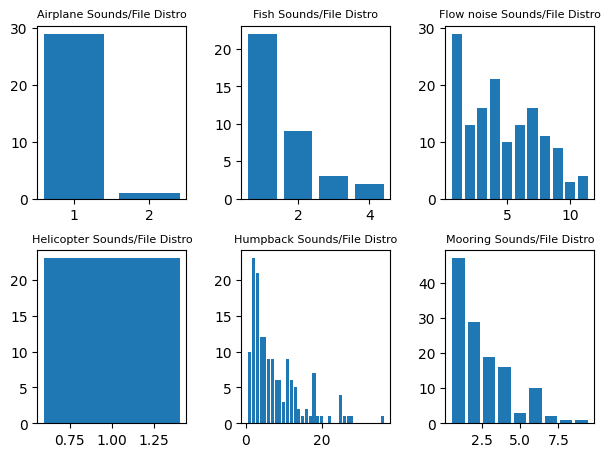

<Figure size 500x200 with 0 Axes>

In [140]:
#Seeing the distribution of sounds per file\
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
fig, axs = plt.subplots(nrows=2, ncols=3)
plt.figure(figsize=(5, 2))
axs[0,0].bar(x=count_files.loc[count_files['sound']=='airplane']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='airplane']['Metadata_files'])
axs[0,1].bar(x=count_files.loc[count_files['sound']=='fish']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='fish']['Metadata_files'])
axs[0,2].bar(x=count_files.loc[count_files['sound']=='flow noise']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='flow noise']['Metadata_files'])
axs[1,0].bar(x=count_files.loc[count_files['sound']=='helicopter']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='helicopter']['Metadata_files'])
axs[1,1].bar(x=count_files.loc[count_files['sound']=='humpback']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='humpback']['Metadata_files'])
axs[1,2].bar(x=count_files.loc[count_files['sound']=='mooring']['spec_sound_count'],
            height = count_files.loc[count_files['sound']=='mooring']['Metadata_files'])
fig.tight_layout(pad = 2.0)
axs[0,0].set_title('Airplane Sounds/File Distro', size = 8)
axs[0,1].set_title('Fish Sounds/File Distro', size = 8)
axs[0,2].set_title('Flow noise Sounds/File Distro', size = 8)
axs[1,0].set_title('Helicopter Sounds/File Distro', size = 8)
axs[1,1].set_title('Humpback Sounds/File Distro', size = 8)
axs[1,2].set_title('Mooring Sounds/File Distro', size = 8)
plt.show()

We can see that few sounds occurr more than 10x per file. Airplanes, Fish, Helicopters and Mooring sounds tend to occur only once per file. VGGish will split sound files into 1 second increments, which amounts to ~30 splits per file. Depending on the duration of the sound this could lead to lots of "dead" time. To give us a good balance and range of sounds, minimize dead time, and maximize the "efficiency" of sounds/wav file we will select a file with ~10 humpback sounds, a file with ~10 mooring sounds, a file with ~10 flow noise sounds, and 2 files with ~5 fish sounds. This equates to 5 files. Ideally we can get a file which has the parameters of the previous sentence PLUS an airplane and/or helicopter noise.

We will start by finding files which have 8-12 whales and/or an airplane and/or a helicopter. Ideally we would use  '20190222T190004-File-28Metadata' to get the WAV with 8 whales and 2 planes, but the metadata file doesn't appear in the MLFigsMeta file. Intsead we will use 20181227T100004-File-6Metadata.

In [148]:
#Creating a giant file with all combos of sounds
wav_select_df = pd.merge(left=sound_distro_df, right=sound_distro_df, how='cross')
#wav_select_df.head()

#Getting list of files with ~10 humpback sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='humpback')
                 & (wav_select_df['spec_sound_count_x'] >=9)
                 & (wav_select_df['spec_sound_count_x'] <= 11)
                 & ((wav_select_df['sound_y']=='airplane') | (wav_select_df['sound_y']=='helicopter'))]

,Metadata_files_x,sound_x,spec_sound_count_x,total_sound_count_x,Metadata_files_y,sound_y,spec_sound_count_y,total_sound_count_y
102879,20190221T100004-File-10Metadata,humpback,11,16,20190221T100004-File-10Metadata,airplane,1,16
103914,20190221T100004-File-15Metadata,humpback,9,13,20190221T100004-File-15Metadata,airplane,1,13
105458,20190221T100004-File-3Metadata,humpback,9,10,20190221T100004-File-3Metadata,airplane,1,10
109064,20190222T190004-File-28Metadata,humpback,11,13,20190222T190004-File-28Metadata,airplane,2,13
128518,20190223T083004-File-18Metadata,humpback,11,12,20190223T083004-File-18Metadata,helicopter,1,12
140613,20181227T100004-File-6Metadata,humpback,11,13,20181227T100004-File-6Metadata,airplane,1,13


Now we pull mooring files. There are no mooring files which contain helicopters or airplanes, so we will take '20181204T203004-File-0Metadata' with 9 identified mooring sounds.

In [162]:
'''#Getting list of files with ~10 mooring sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='mooring')
                 & (wav_select_df['spec_sound_count_x'] >=8)
                 & (wav_select_df['spec_sound_count_x'] <=12)
                 & ((wav_select_df['sound_y']=='airplane') | (wav_select_df['sound_y']=='helicopter'))]'''

#Getting list of files with ~10 mooring sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='mooring')
                 & (wav_select_df['spec_sound_count_x'] >=8)
                 & (wav_select_df['spec_sound_count_x'] <=12)]

,Metadata_files_x,sound_x,spec_sound_count_x,total_sound_count_x,Metadata_files_y,sound_y,spec_sound_count_y,total_sound_count_y
14504,20181209T053004-File-23Metadata,mooring,8,9,20181209T053004-File-23Metadata,mooring,8,9
14848,20181209T053004-File-23Metadata,mooring,8,9,20181209T053004-File-23Metadata,flow noise,1,9
50246,20181204T203004-File-0Metadata,mooring,9,9,20181204T203004-File-0Metadata,mooring,9,9


Next we will get our list of flow noise files with airplanes/helicopters. Ideally we would have used  '20190221T100004-File-13Metadata' because it has both flow noise and a helicopter. However, this metadata file wasn't available. Instead we used 20181209T083004-File-21Metadata. 

In [171]:
'''#Getting list of files with ~10 fish sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='flow noise')
                 & (wav_select_df['spec_sound_count_x'] >=8)
                 & (wav_select_df['spec_sound_count_x'] <=12)
                 & ((wav_select_df['sound_y']=='airplane') | (wav_select_df['sound_y']=='helicopter'))]'''

#Getting list of files with ~10 fish sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='flow noise')
                 & (wav_select_df['spec_sound_count_x'] >=8)
                 & (wav_select_df['spec_sound_count_x'] <=12)]

,Metadata_files_x,sound_x,spec_sound_count_x,total_sound_count_x,Metadata_files_y,sound_y,spec_sound_count_y,total_sound_count_y
159997,20190129T160004-File-7Metadata,flow noise,8,14,20190129T160004-File-7Metadata,humpback,6,14
160062,20190129T160004-File-7Metadata,flow noise,8,14,20190129T160004-File-7Metadata,flow noise,8,14
166170,20190131T053004-File-19Metadata,flow noise,8,14,20190131T053004-File-19Metadata,humpback,6,14
166278,20190131T053004-File-19Metadata,flow noise,8,14,20190131T053004-File-19Metadata,flow noise,8,14
166476,20181209T083004-File-21Metadata,flow noise,9,14,20181209T083004-File-21Metadata,mooring,5,14
166796,20181209T083004-File-21Metadata,flow noise,9,14,20181209T083004-File-21Metadata,flow noise,9,14
167233,20190129T130004-File-22Metadata,flow noise,8,12,20190129T130004-File-22Metadata,humpback,4,12
167314,20190129T130004-File-22Metadata,flow noise,8,12,20190129T130004-File-22Metadata,flow noise,8,12
168038,20181209T173004-File-18Metadata,flow noise,9,13,20181209T173004-File-18Metadata,mooring,4,13
168350,20181209T173004-File-18Metadata,flow noise,9,13,20181209T173004-File-18Metadata,flow noise,9,13


Now we need to get 2 fish files with ~5 recordings each, and ideally some airplanes and/or helicopters. Unfortunately there are none so We will select '20181227T053004-File-10Metadata' and '20181227T100004-File-20Metadata'

In [165]:
#Getting list of files with ~10 fish sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='fish')
                 & (wav_select_df['spec_sound_count_x'] >=4)
                 & ((wav_select_df['sound_y']=='airplane') | (wav_select_df['sound_y']=='helicopter'))]

#Getting list of files with ~10 fish sounds and/or and airplane sound
wav_select_df.loc[(wav_select_df['Metadata_files_x']==wav_select_df['Metadata_files_y'])
                 & (wav_select_df['sound_x']=='fish')
                 & (wav_select_df['spec_sound_count_x'] >=4)]

,Metadata_files_x,sound_x,spec_sound_count_x,total_sound_count_x,Metadata_files_y,sound_y,spec_sound_count_y,total_sound_count_y
245532,20181227T053004-File-10Metadata,fish,4,4,20181227T053004-File-10Metadata,fish,4,4
248441,20181227T100004-File-20Metadata,fish,4,7,20181227T100004-File-20Metadata,humpback,3,7
248640,20181227T100004-File-20Metadata,fish,4,7,20181227T100004-File-20Metadata,fish,4,7


Now we create our final list of metadata files we need to bring over from the external hard drive to find the associated WAV files.

In [172]:
metadata_file_list = ['20181227T053004-File-10Metadata','20181227T100004-File-20Metadata',
                      '20181209T083004-File-21Metadata',  '20181204T203004-File-0Metadata',
                      '20181227T100004-File-6Metadata']
print("The Metadata files which contain annotated spectrograms from the October 26th annotation batch and will be used in our POC are:")
print(metadata_file_list)

The Metadata files which contain annotated spectrograms from the October 26th annotation batch and will be used in our POC are:
['20181227T053004-File-10Metadata', '20181227T100004-File-20Metadata', '20181209T083004-File-21Metadata', '20181204T203004-File-0Metadata', '20181227T100004-File-6Metadata']


In [176]:
print('20190221T100004-File-13.png has no metadata file')
print('     Used 20181209T083004-File-21Metadata for flow noise instead')
print('20190222T190004-File-28.png has no metadata file')
print('     Used 20181227T100004-File-6Metadata for whales instead')

20190221T100004-File-13.png has no metadata file
     Used 20181209T083004-File-21Metadata for flow noise instead
20190222T190004-File-28.png has no metadata file
     Used 20181227T100004-File-6Metadata for whales instead
